In [77]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns 
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import Sequence
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense

# Load Dataset
The data is the measurements of electric power consumption in one household with a one-minute sampling rate over a period of almost 4 years

In [78]:
df = pd.read_csv('household_power_consumption.txt', sep=';',
                 parse_dates={'date_time' : ['Date', 'Time']}, dayfirst=True,
                 low_memory=False, na_values=['nan','?'])

# Feature Engineering

In [79]:
df.head()

,date_time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
1,2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2,2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
3,2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
4,2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0


Different electrical quantities and some sub-metering values are available. However, we are only interested in Global_active_power variable.



In [80]:
df.shape

(2075259, 8)

In [81]:
df.isnull().sum()

date_time                    0
Global_active_power      25979
Global_reactive_power    25979
Voltage                  25979
Global_intensity         25979
Sub_metering_1           25979
Sub_metering_2           25979
Sub_metering_3           25979
dtype: int64

In [82]:
df=df.dropna(subset=['Global_active_power'])

In [83]:
df['year']=df['date_time'].apply(lambda x:x.year)
df['quarter']=df['date_time'].apply(lambda  x:x.quarter)
df['month']=df['date_time'].apply(lambda x:x.month)
df['day']=df['date_time'].apply(lambda x:x.day)
df=df.loc[:,['date_time','Global_active_power','year','quarter','month','day']]
df.sort_values('date_time',inplace=True,ascending=True)
df=df.reset_index(drop=True)
# df['weekday']=df.apply(lambda row : row['date_time'].weekday(),axis=1)
# df["weekday"]=(df['weekday']<5).astype(int)


print('Number of rows and columns after removing missing values:',df.shape)
print('The time series starts from:',df['date_time'].min())
print('The time series ends on:',df['date_time'].max())

Number of rows and columns after removing missing values: (2049280, 6)
The time series starts from: 2006-12-16 17:24:00
The time series ends on: 2010-11-26 21:02:00


In [84]:
df.head()

,date_time,Global_active_power,year,quarter,month,day
0,2006-12-16 17:24:00,4.216,2006,4,12,16
1,2006-12-16 17:25:00,5.360,2006,4,12,16
2,2006-12-16 17:26:00,5.374,2006,4,12,16
3,2006-12-16 17:27:00,5.388,2006,4,12,16
4,2006-12-16 17:28:00,3.666,2006,4,12,16


In [85]:
df.isnull().sum()

date_time              0
Global_active_power    0
year                   0
quarter                0
month                  0
day                    0
dtype: int64

# EDA

In [86]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2049280 entries, 0 to 2049279
Data columns (total 6 columns):
 #   Column               Dtype         
---  ------               -----         
 0   date_time            datetime64[ns]
 1   Global_active_power  float64       
 2   year                 int64         
 3   quarter              int64         
 4   month                int64         
 5   day                  int64         
dtypes: datetime64[ns](1), float64(1), int64(4)
memory usage: 93.8 MB


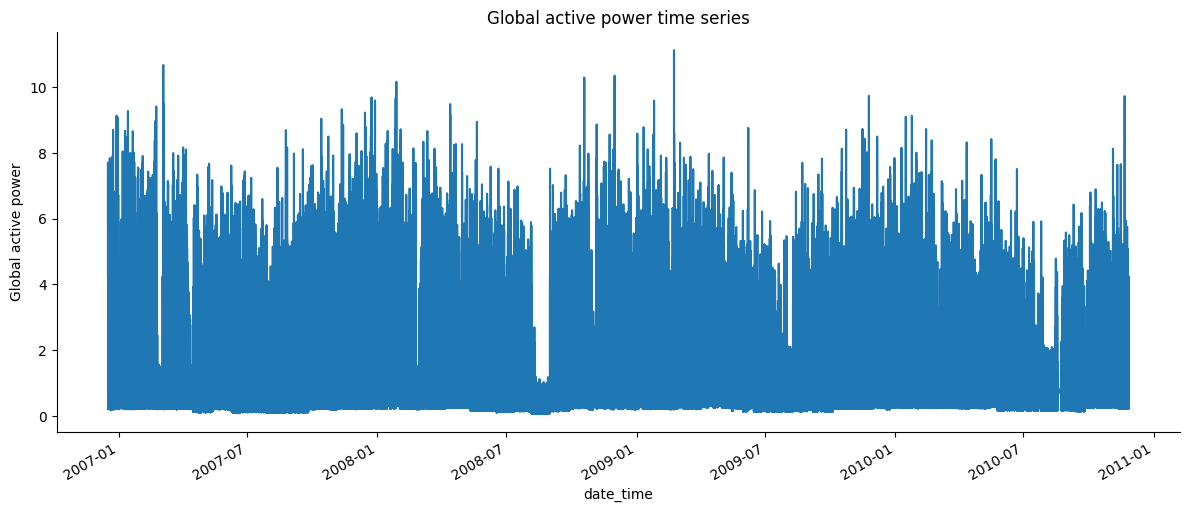

In [87]:
# Draw time series plot
df1=df.loc[:,['date_time' ,'Global_active_power']]
df1.set_index('date_time',inplace=True)
df1.plot(figsize=(12,5))
plt.ylabel('Global active power')
plt.legend().set_visible(False)
plt.tight_layout()
plt.title('Global active power time series')
sns.despine(top=True)
plt.show()

## Box Plot of Yearly vs. Quarterly Global Active Power

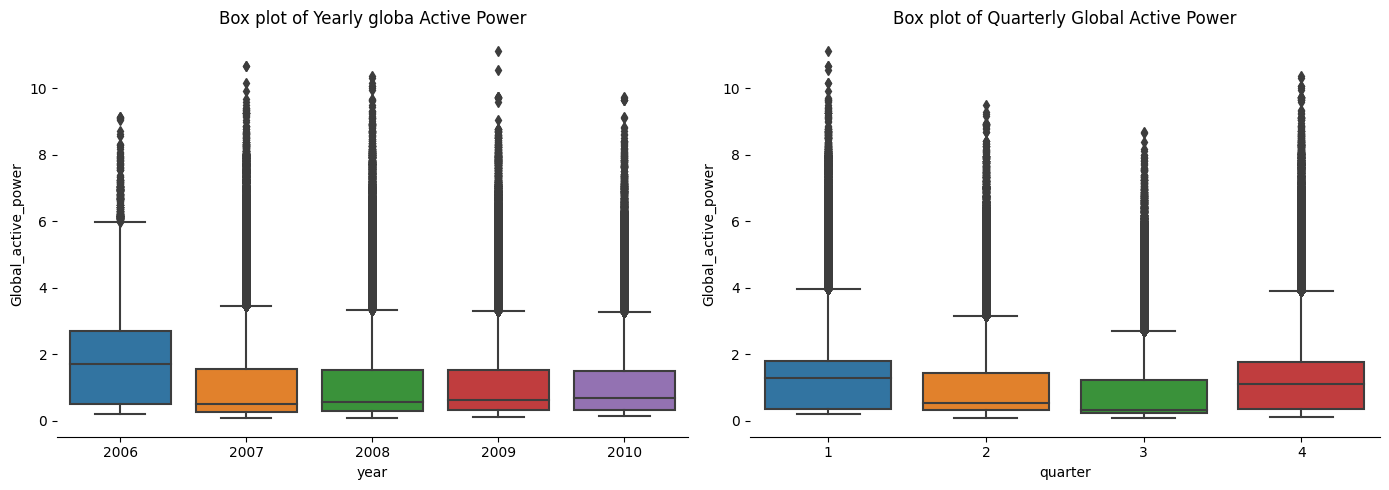

In [88]:
# Box plot of yearly vs quartly global active power
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.subplots_adjust(wspace=0.2)
sns.boxplot(x='year', y='Global_active_power',data=df)
plt.xlabel('year')
plt.title('Box plot of Yearly globa Active Power')
sns.despine(left=True)
plt.tight_layout()

plt.subplot(1,2,2)
sns.boxplot(x='quarter',y='Global_active_power',data=df)
plt.xlabel('quarter')
plt.title('Box plot of Quarterly Global Active Power')
sns.despine(left=True)
plt.tight_layout()

The median global active power in 2006 is much higher than the other years’. This is a little bit misleading. 

## Global Active Power Distribution

,count,mean,std,min,25%,50%,75%,max
Global_active_power,2049280.0,1.091615,1.057294,0.076,0.308,0.602,1.528,11.122


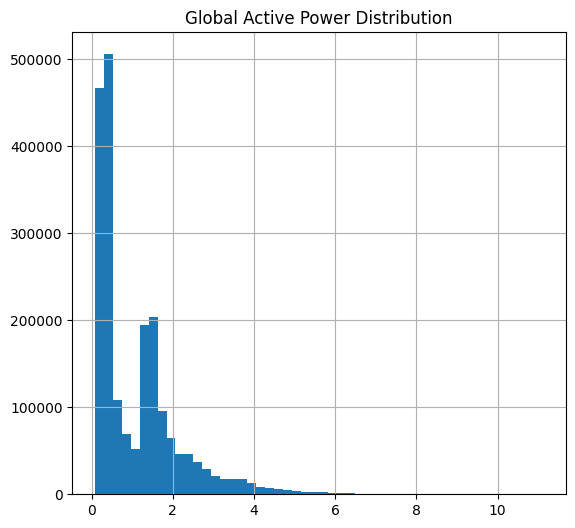

In [89]:
# Check the distribution
plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
df['Global_active_power'].hist(bins=50)
plt.title('Global Active Power Distribution')

df1.describe().T

Normal probability plot also shows the data is far from normally distributed.

## Plot Mean Global Active Power Grouped by Year, Quarter, Month and Day

Text(0.5, 1.0, 'Mean global active power by day')

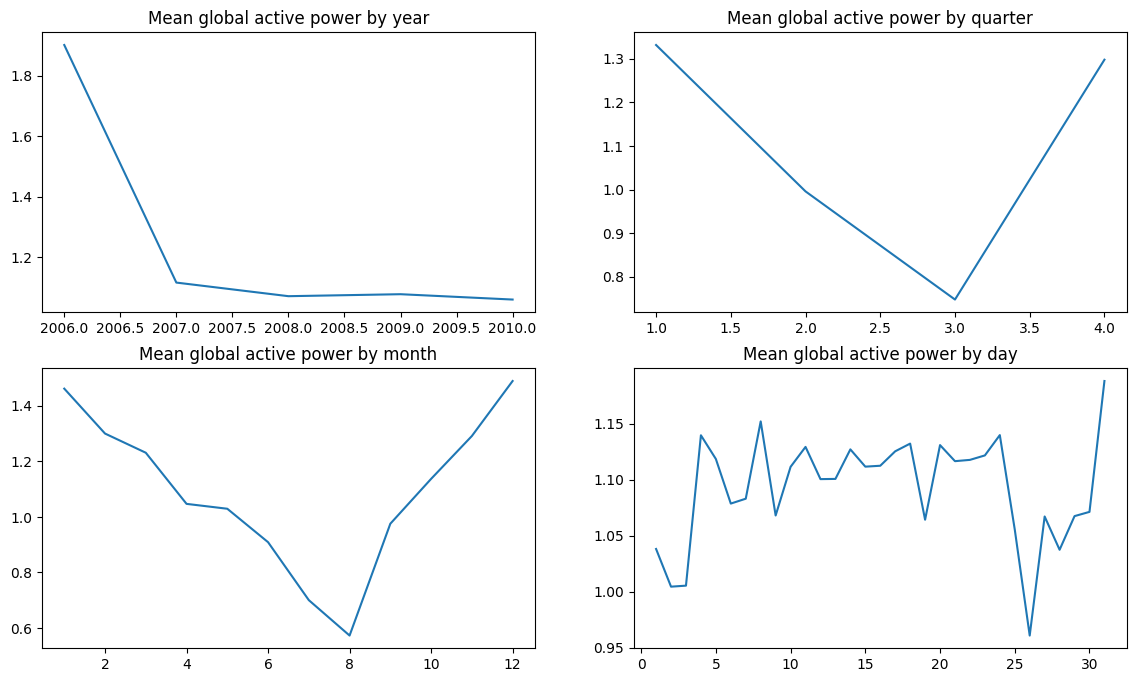

In [90]:
# Plot mean global active power grouped by year, quarter,monh and day

plt.figure(figsize=(14,8))
plt.subplot(2,2,1)
df.groupby('year').Global_active_power.agg('mean').plot()
plt.xlabel('')
plt.title('Mean global active power by year')

plt.subplot(2,2,2)
df.groupby('quarter').Global_active_power.agg('mean').plot()
plt.xlabel('')
plt.title('Mean global active power by quarter')

plt.subplot(2,2,3)
df.groupby('month').Global_active_power.agg('mean').plot()
plt.xlabel('')
plt.title('Mean global active power by month')

plt.subplot(2,2,4)
df.groupby('day').Global_active_power.agg('mean').plot()
plt.xlabel('')
plt.title('Mean global active power by day')

The above plots confirmed our previous discoveries. By year, it was steady. By quarter, the lowest average power consumption was in the 3rd quarter. By month, the lowest average power consumption was in July and August. By day, the lowest average power consumption was around 8th of the month.

## Global Active Power by Years
This time, we remove 2006.

array([[<Axes: xlabel='month'>, <Axes: xlabel='month'>,
        <Axes: xlabel='month'>, <Axes: xlabel='month'>,
        <Axes: xlabel='month'>],
       [<Axes: xlabel='month'>, <Axes: xlabel='month'>,
        <Axes: xlabel='month'>, <Axes: xlabel='month'>,
        <Axes: xlabel='month'>],
       [<Axes: xlabel='month'>, <Axes: xlabel='month'>,
        <Axes: xlabel='month'>, <Axes: xlabel='month'>,
        <Axes: xlabel='month'>]], dtype=object)

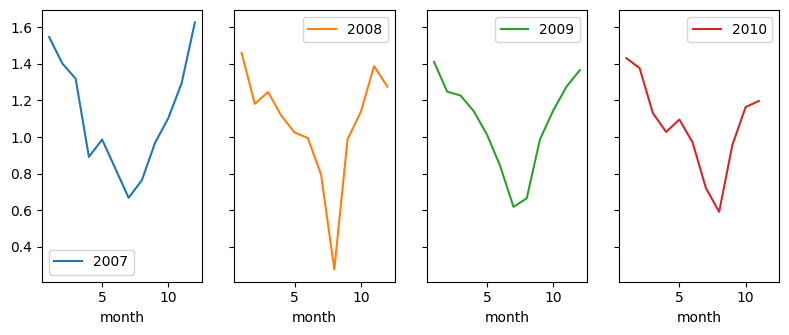

In [91]:
#We remove 2006 because other years have similar pattern.
pd.pivot_table(df.loc[df['year']!=2006],values='Global_active_power',columns='year',index='month').plot(subplots=True,figsize=(12,12),layout=(3,5),sharey=True)

# Split data into train and test

In [92]:
dataset=df.Global_active_power.values
dataset=dataset.astype('float32')
dataset=np.reshape(dataset,(-1,1))

In [93]:
scaler=MinMaxScaler(feature_range=(0,1))
dataset=scaler.fit_transform(dataset)
train_size=int(len(dataset)*0.8)
test_size=len(dataset)-train_size
train,test =dataset[0:train_size,:],dataset[train_size:len(dataset),:]

# Auto Regression

In [94]:
from statsmodels.tsa.ar_model import AutoReg
ar_model = AutoReg(train, lags=50).fit()
print(ar_model.summary())

                            AutoReg Model Results                             
Dep. Variable:                      y   No. Observations:              1639424
Model:                    AutoReg(50)   Log Likelihood             3756818.750
Method:               Conditional MLE   S.D. of innovations              0.024
Date:                Tue, 08 Aug 2023   AIC                       -7513533.499
Time:                        13:19:43   BIC                       -7512893.389
Sample:                            50   HQIC                      -7513360.761
                              1639424                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0017   2.86e-05     58.110      0.000       0.002       0.002
y.L1           1.0039      0.001   1285.416      0.000       1.002       1.005
y.L2          -0.1422      0.001   -128.511      0.0

## Prediction

predicted=0.032548, expected=0.042368
predicted=0.033002, expected=0.040920
predicted=0.033281, expected=0.040920
predicted=0.033849, expected=0.040377
predicted=0.034613, expected=0.041282
predicted=0.035764, expected=0.039652
predicted=0.036628, expected=0.039652
Test RMSE: 0.082


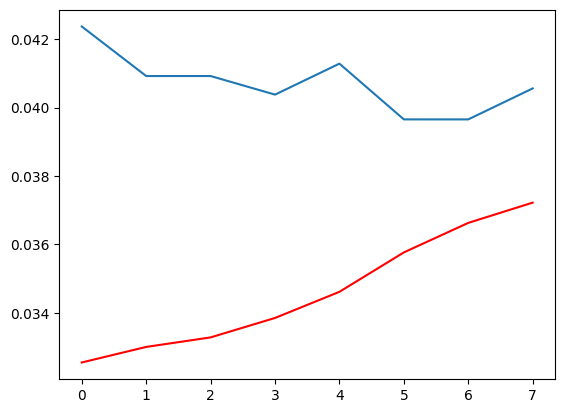

In [106]:
from math import sqrt
# Predictions
pred_ar = ar_model.predict(start=len(train), end=len(dataset)-1, dynamic=False)
for i in range(7):
    print('predicted=%f, expected=%f' % (pred_ar[i], test[i]))
    # print('predicted=%f, expected=%f' % (round(pred_ar[i]), round(float(test[i]))))
    
rmse_ar = sqrt(mean_squared_error(test, pred_ar))
print('Test RMSE: %.3f' % rmse_ar)

# plot results
plt.plot(test[:8])
plt.plot(pred_ar[:8], color='red')
plt.show()

## Future pridiction

In [97]:
from datetime import timedelta
future_ar = ar_model.predict(start=len(dataset)+1, end=len(dataset)+7, dynamic=False)
# store the last date of the dataset
last_date = df['date_time'][len(dataset)-1]
time = []
pred_value = []
for i in range(0,7):
    time.append((last_date + timedelta(minutes=i+1)))
    pred_value.append(future_ar[i])

# show with pandas
show = pd.DataFrame({'date_time':time, 'value':pred_value})
show

,date_time,value
0,2010-11-26 21:03:00,0.093623
1,2010-11-26 21:04:00,0.093623
2,2010-11-26 21:05:00,0.093623
3,2010-11-26 21:06:00,0.093623
4,2010-11-26 21:07:00,0.093623
5,2010-11-26 21:08:00,0.093623
6,2010-11-26 21:09:00,0.093623


# Prepare dataset for LSTM

In [98]:
def create_dataset(dataset, look_back=1):
  x,y=[],[]
  for i in range(len(dataset)-look_back-1):
    a=dataset[i:(i+look_back),0]
    x.append(a)
    y.append(dataset[i+look_back,0])
  return np.array(x),np.array(y)

'''
The variable look_back is used in the context of time series forecasting with recurrent neural networks (RNNs), 
particularly with the Long Short-Term Memory (LSTM) networks. 
The purpose of look_back is to define the number of previous time steps that will be used as input features to predict the next time step.
'''
look_back=30


x_train,y_train=create_dataset(train,look_back)
x_test,y_test=create_dataset(test,look_back)

# Reshape inputs 
x_train= np.reshape(x_train,(x_train.shape[0],1,x_train.shape[1]))
x_test=np.reshape(x_test,(x_test.shape[0],1,x_test.shape[1]))

# LSTM

In [99]:
# Train the model
model=tf.keras.Sequential()
model.add(LSTM(100,input_shape=(x_train.shape[1],x_train.shape[2])))
model.add(tf.keras.layers.Dropout(0.2))
model.add(Dense(32))
model.add(Dense(16))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

history=model.fit(x_train,y_train, epochs=20, batch_size=70,validation_data=(x_test,y_test),
                  callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=10)],verbose=1,shuffle=False)
model.summary()

Epoch 1/20
23420/23420 [==============================] - 53s 2ms/step - loss: 8.2184e-04 - val_loss: 3.9946e-04
Epoch 2/20
23420/23420 [==============================] - 52s 2ms/step - loss: 6.7778e-04 - val_loss: 3.9900e-04
Epoch 3/20
23420/23420 [==============================] - 50s 2ms/step - loss: 6.5571e-04 - val_loss: 4.0234e-04
Epoch 4/20
23420/23420 [==============================] - 51s 2ms/step - loss: 6.4391e-04 - val_loss: 3.9523e-04
Epoch 5/20
23420/23420 [==============================] - 54s 2ms/step - loss: 6.4126e-04 - val_loss: 4.1156e-04
Epoch 6/20
23420/23420 [==============================] - 51s 2ms/step - loss: 6.3789e-04 - val_loss: 3.9075e-04
Epoch 7/20
23420/23420 [==============================] - 50s 2ms/step - loss: 6.3458e-04 - val_loss: 3.9320e-04
Epoch 8/20
23420/23420 [==============================] - 53s 2ms/step - loss: 6.3155e-04 - val_loss: 3.9505e-04
Epoch 9/20
23420/23420 [==============================] - 53s 2ms/step - loss: 6.3111e-04 - val_

## Predictions and result

In [100]:
#Make predictions
from sklearn.metrics import mean_absolute_error
train_predict = model.predict(x_train)
test_predict = model.predict(x_test)


12808/12808 [==============================] - 12s 950us/step


In [101]:
# invert predictions
train_predict = scaler.inverse_transform(train_predict)
y_train = scaler.inverse_transform([y_train])
test_predict = scaler.inverse_transform(test_predict)
y_test = scaler.inverse_transform([y_test])
rmse_lstm = np.sqrt(mean_squared_error(y_test[0], test_predict[:,0]))
print('Train Root Mean Squared Error:',rmse_lstm)

Train Root Mean Squared Error: 0.21764020883035673


## Pradiction

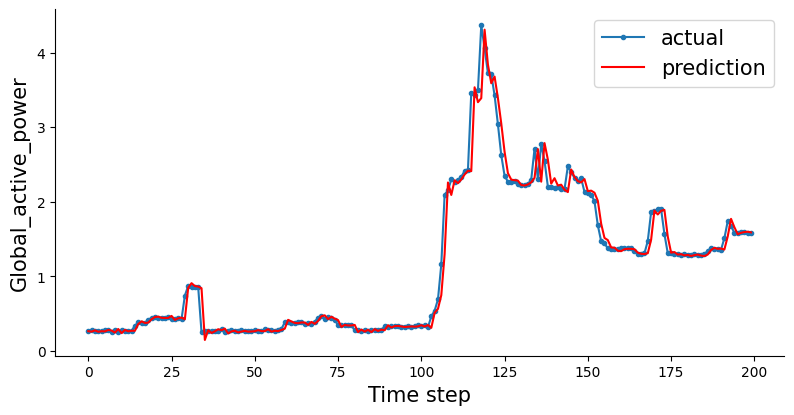

In [109]:
#Compare actual vs predicted for last 200 minutes

aa=[x for x in range(200)]
plt.figure(figsize=(8,4))
plt.plot(aa, y_test[0][:200], marker='.', label="actual")
plt.plot(aa, test_predict[:,0][:200], 'r', label="prediction")
# plt.tick_params(left=False, labelleft=True) #remove ticks
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.ylabel('Global_active_power', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show()

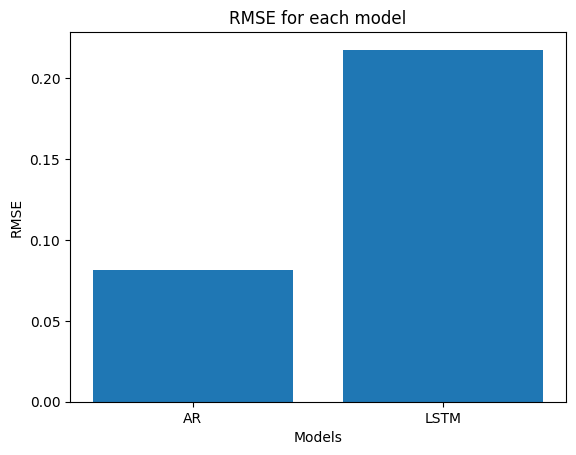

,Model,RMSE
0,AR,0.081558
1,LSTM,0.217640


In [108]:
#Comparing rsme for each model
rsme_scores = [rmse_ar, rmse_lstm]
models = ['AR','LSTM']
plt.bar(models, rsme_scores)
plt.xlabel('Models')
plt.ylabel('RMSE')
plt.title('RMSE for each model')
plt.show()
#make table
data = {'Model': models, 'RMSE': rsme_scores}
results = pd.DataFrame(data)
sort_results = results.sort_values('RMSE')
sort_results

# Multivariate Time Series Analysis on Household Energy Consumption Dataset with Autoregression and LSTM

# Introduction:
This study presents a comprehensive analysis of a multivariate multi-step time series dataset related to household energy consumption. The analysis focuses on applying two different approaches to forecast energy consumption: Autoregressive (AR) models and Long Short-Term Memory (LSTM) networks. The dataset includes multiple variables, enabling the exploration of complex relationships and patterns within energy consumption data.

# Autoregressive (AR) Models:
The AR model uses the past values of a time series to predict future values. It assumes that the future value depends linearly on its past values and a random error term. The order of the AR model, denoted as AR(p), indicates the number of lagged values used for prediction.

# Long Short-Term Memory (LSTM) Networks:
LSTM is a type of recurrent neural network (RNN) designed to model sequences and time series data. It is well-suited for capturing long-range dependencies in data. LSTM networks contain memory cells that allow them to learn and remember patterns over extended sequences.

# Steps of Analysis:

1. Data Preprocessing:

- Load and inspect the dataset.
- Handle missing values, if any, through interpolation or imputation.
- Normalize the data to ensure all variables are on the same scale.

2. Exploratory Data Analysis (EDA):

- Visualize the time series data to understand trends, seasonality, and potential outliers.
- Explore the relationships between the variables.

3. Feature Engineering:

- Prepare input sequences and corresponding target values for LSTM modeling.
- Split the dataset into training and test sets.
- Remove unnecessary variables from the dataset.
- Add day, month, and year columns to the dataset.

4. Evaluation:

- Evaluate the performance of both Autoregressive and LSTM models using RMSE.
Compare the models' accuracy and generalization capabilities.

5. Prediction and Visualization:

- Make predictions and future prediction using Autoregressive.
- Visualize the predicted energy consumption compared to the actual values using LSTM.

# RMSE Comparison:

1. Autoregression (AR) Model:

- RMSE Value: 0.081558
2. Long Short-Term Memory (LSTM) Network:

- RMSE Value: 0.217640
# Conclusion:
The analysis of the Household Energy Consumption dataset exemplifies the application of Autoregression (AR) and Long Short-Term Memory (LSTM) techniques for time series forecasting. The RMSE comparison reveals that the Autoregression model outperforms the LSTM network, as it exhibits a substantially lower RMSE value. This documentation provides a comprehensive overview of the analysis process, affording readers a comprehensive grasp of the AR and LSTM models' performance in forecasting energy consumption within a multivariate time series context, elucidated through the RMSE metric.